--- System Configuration ---
Sampling Rate: 2.50 GHz | Samples per Pulse: 5000
Max Range: 299.8 m | Range Resolution: 0.675 m
Total Pulses: 2048 | Observation Time: 4.096 ms
Velocity Res: 0.475 m/s
--- Target Amplitudes (Fixed) ---
Target 1 (50m): 0.9 | Target 2 (135m): 0.9

Initialization Complete. Pulse generated.


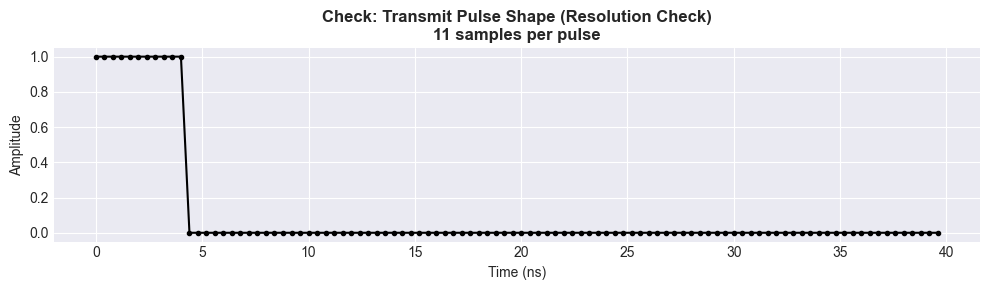

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import pandas as pd
import time

plt.style.use("seaborn-v0_8-darkgrid")

# =============================================================================
# 1. RADAR SYSTEM PARAMETERS
# =============================================================================
C = 299_792_358         # Speed of light (m/s)
FC = 77e9               # Carrier Frequency (77 GHz)
LAMBDA = C / FC         # Wavelength (~3.9 mm)

# Timing Parameters
PRI = 2e-6              # Pulse Repetition Interval (2 us) => Max Range = 300m
PRF = 1 / PRI           # Pulse Repetition Frequency (500 kHz)
TP = 4.5e-9             # Pulse Width (4.5 ns) => Range Resolution ~0.675m

# Sampling Parameters
# We need to resolve a 4.5ns pulse. Sampling at 0.4ns gives ~11 samples per pulse.
DT = 0.4e-9             # Sampling Time (0.4 ns)
N = int(PRI / DT)       # Samples per PRI (5000)
FS = 1 / DT             # Sampling Rate (2.5 GHz)

# Doppler / Experiment Duration
# Res = Lambda / (2 * N * PRI) = 0.0039 / (2 * 2048 * 2e-6) = 0.47 m/s
N_PULSES = 2048         
Tosv = N_PULSES * PRI   # Total Observation Time (~4 ms)

NOISE_SNR = -5         # Target SNR in dB

# =============================================================================
# 2. TARGET SCENARIO & FIXED AMPLITUDE
# =============================================================================
FIXED_AMP = 0.9

# Target 1: Close & Approaching
RANGE_1 = 50.0          # Meters
VELOCITY_1 = -20.0      # m/s (Approaching)
A1 = FIXED_AMP          

# Target 2: Far & Receding
RANGE_2 = 135.0         # Meters
VELOCITY_2 = 35.0       # m/s (Receding)
A2 = FIXED_AMP          

print(f"--- System Configuration ---")
print(f"Sampling Rate: {FS/1e9:.2f} GHz | Samples per Pulse: {N}")
print(f"Max Range: {(C*PRI)/2:.1f} m | Range Resolution: {(C*TP)/2:.3f} m")
print(f"Total Pulses: {N_PULSES} | Observation Time: {Tosv*1000:.3f} ms")
print(f"Velocity Res: {LAMBDA/(2*Tosv):.3f} m/s")
print(f"--- Target Amplitudes (Fixed) ---")
print(f"Target 1 (50m): {A1} | Target 2 (135m): {A2}")

# =============================================================================
# 3. HELPER FUNCTIONS
# =============================================================================

def add_complex_noise(sig, snr_db):
    """
    Adds complex Gaussian White Noise to a signal for a specific SNR.
    Calculates noise power based on the PEAK of the signal.
    """
    # Calculate Peak Signal Power (Active Pulse)
    sig_peak_power = np.max(np.abs(sig)) ** 2
    
    if sig_peak_power == 0:
        sig_peak_power = 1e-12
        
    sig_peak_power_db = 10 * np.log10(sig_peak_power)

    # Calculate required noise power relative to Peak
    noise_avg_db = sig_peak_power_db - snr_db
    noise_avg_watt = 10 ** (noise_avg_db / 10)

    # Generate complex noise
    noise_power_per_channel = noise_avg_watt / 2
    noise = (np.random.normal(0, np.sqrt(noise_power_per_channel), len(sig)) +
             1j * np.random.normal(0, np.sqrt(noise_power_per_channel), len(sig)))
    
    return sig + noise

def time_to_index(t_val):
    """Converts a time value (seconds) to an array index."""
    return int(np.round(t_val / DT))

def shift_signal(sig, delay_samples):
    """
    Shifts a signal by a specific number of samples (delay).
    Fills empty space with zeros.
    """
    result = np.zeros_like(sig)
    if delay_samples < len(sig):
        result[delay_samples:] = sig[:len(sig)-delay_samples]
    return result

# =============================================================================
# 4. GENERATE BASEBAND PULSE & SANITY CHECK
# =============================================================================
t = np.linspace(0, PRI, N, endpoint=False)
sig = np.zeros(N, dtype=complex)

# Create Rectangular Pulse
sig[:time_to_index(TP)] = 1.0 + 0j

print("\nInitialization Complete. Pulse generated.")

# --- SANITY CHECK PLOT ---
plt.figure(figsize=(10, 3))
plt.plot(t[:100]*1e9, np.real(sig[:100]), '.-', color='black', linewidth=1.5)
plt.title(f"Check: Transmit Pulse Shape (Resolution Check)\n{time_to_index(TP)} samples per pulse", fontweight='bold')
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

Generating Visualization with Fixed Amplitudes: A1=0.9, A2=0.9


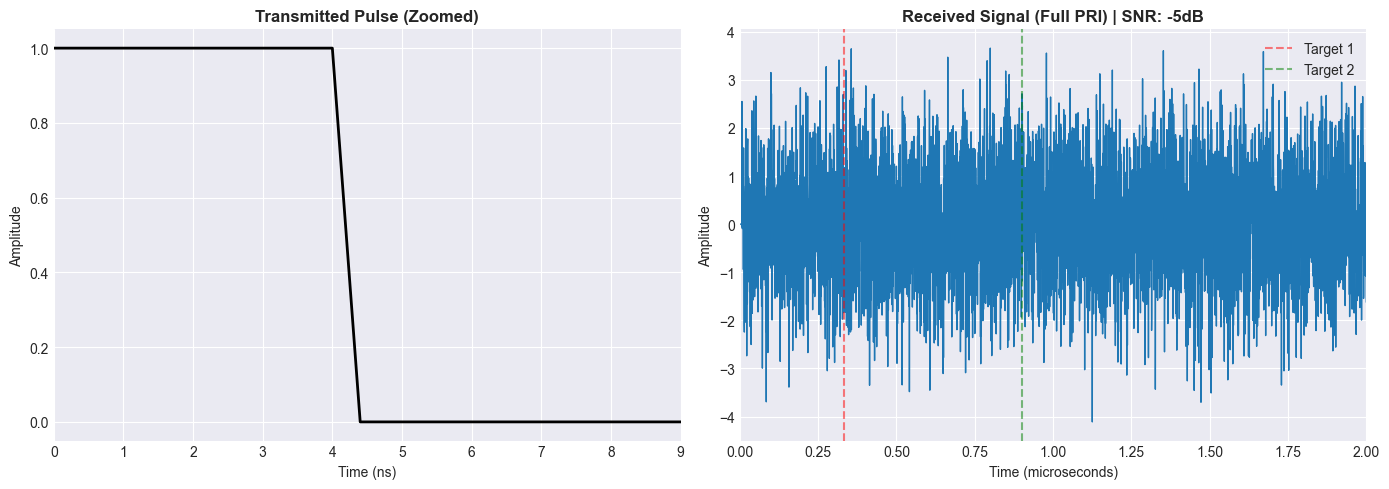

In [2]:
# =============================================================================
# 5. DEFINE FILTER REGION (Receiver Blanking)
# =============================================================================
filter_region = np.ones(N)
filter_region[:time_to_index(TP) + 5] = 0

# =============================================================================
# 6. SIGNAL GENERATION FUNCTIONS
# =============================================================================

def generate_complex_echo(mag1, mag2, pulse_idx=0):
    """
    Generates the COMPLEX return signal.
    REPLACES 'get_received_echo_real' to support Doppler Processing.
    """
    # Echo 1 (Target 1)
    delay1 = time_to_index(2 * RANGE_1 / C)
    # Phase shift is crucial for Doppler: exp(-j * 4pi * R / lambda)
    phase1 = np.exp(-1j * 4 * np.pi * RANGE_1 / LAMBDA) 
    # Use global 'sig' (tx_sig from prev block)
    rec1 = mag1 * shift_signal(sig, delay1) * phase1
    
    # Echo 2 (Target 2)
    delay2 = time_to_index(2 * RANGE_2 / C)
    phase2 = np.exp(-1j * 4 * np.pi * RANGE_2 / LAMBDA)
    rec2 = mag2 * shift_signal(sig, delay2) * phase2
    
    # Combine Complex Signals
    clean_combined = rec1 + rec2
    
    # Add Complex Noise (Using helper from Block 1)
    # Note: SNR is now relative to the Fixed Amplitude (1.0)
    noisy_complex = add_complex_noise(clean_combined, NOISE_SNR)
    
    # Apply Blanking to remove Tx leakage
    noisy_complex = noisy_complex * filter_region
    
    return noisy_complex

# =============================================================================
# 7. PLOTTING FUNCTIONS
# =============================================================================

def plot_signals_transmitted_recieved(t, transmitted_signal, received_signal):
    t_us = t * 1e6   # Convert to microseconds
    t_ns = t * 1e9   # Convert to nanoseconds
    
    # Take REAL part for visualization (simulating an oscilloscope)
    rx_real = np.real(received_signal)
    
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 5))
    
    # PLOT 1: Transmitted Pulse
    ax1.plot(t_ns, np.real(transmitted_signal), color='black', linewidth=2)
    ax1.set_title("Transmitted Pulse (Zoomed)", fontsize=12, fontweight='bold')
    ax1.set_xlabel("Time (ns)")
    ax1.set_ylabel("Amplitude")
    ax1.set_xlim(0, TP * 1e9 * 2)
    ax1.grid(True)

    # PLOT 2: Received Signal
    ax2.plot(t_us, rx_real, color='#1f77b4', linewidth=1)
    ax2.set_title(f"Received Signal (Full PRI) | SNR: {NOISE_SNR}dB", fontsize=12, fontweight='bold')
    ax2.set_xlabel("Time (microseconds)")
    ax2.set_ylabel("Amplitude")
    ax2.set_xlim(0, PRI * 1e6)
    
    # Annotate the Targets
    t1_us = (2 * RANGE_1 / C) * 1e6
    t2_us = (2 * RANGE_2 / C) * 1e6
    
    ax2.axvline(t1_us, color='red', linestyle='--', alpha=0.5, label='Target 1')
    ax2.axvline(t2_us, color='green', linestyle='--', alpha=0.5, label='Target 2')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# 8. EXECUTE VISUALIZATION
# =============================================================================
print(f"Generating Visualization with Fixed Amplitudes: A1={A1}, A2={A2}")

# Generate the signal
rx_vis_signal = generate_complex_echo(A1, A2)

plot_signals_transmitted_recieved(t, sig, rx_vis_signal)

Noise Sigma (Est): 1.95692e+00
Dynamic Threshold (k=2): 3.91384e+00
Min Peak Separation (indices): 11
Found 14 peaks at indices: [ 310  829 1437 1632 1972 2058 2541 2589 2711 2926 3104 3164 3199 3815]
  Peak 1: 18.59 meters
  Peak 2: 49.71 meters
  Peak 3: 86.16 meters
  Peak 4: 97.85 meters
  Peak 5: 118.24 meters
  Peak 6: 123.39 meters
  Peak 7: 152.35 meters
  Peak 8: 155.23 meters
  Peak 9: 162.55 meters
  Peak 10: 175.44 meters
  Peak 11: 186.11 meters
  Peak 12: 189.71 meters
  Peak 13: 191.81 meters
  Peak 14: 228.74 meters


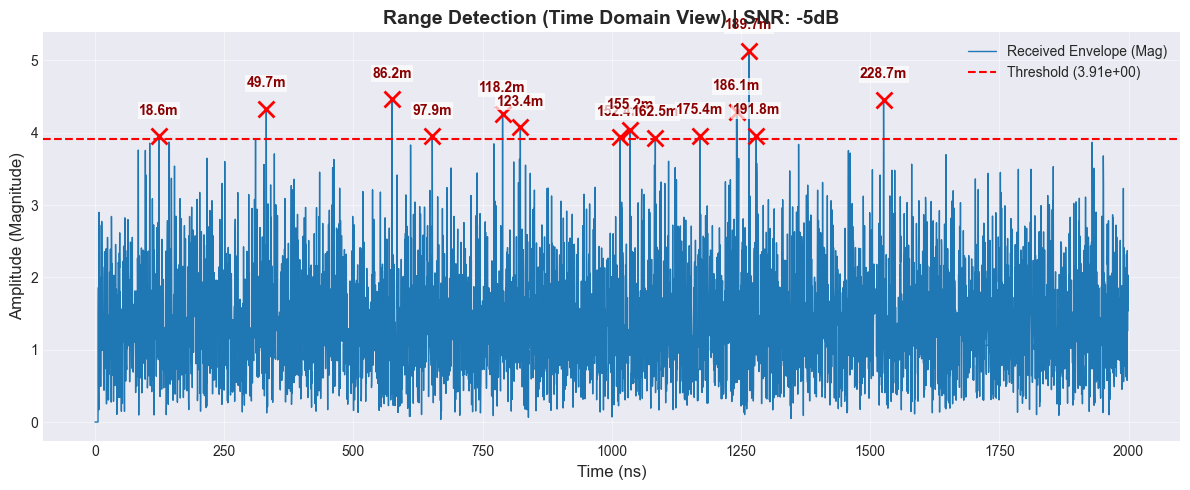

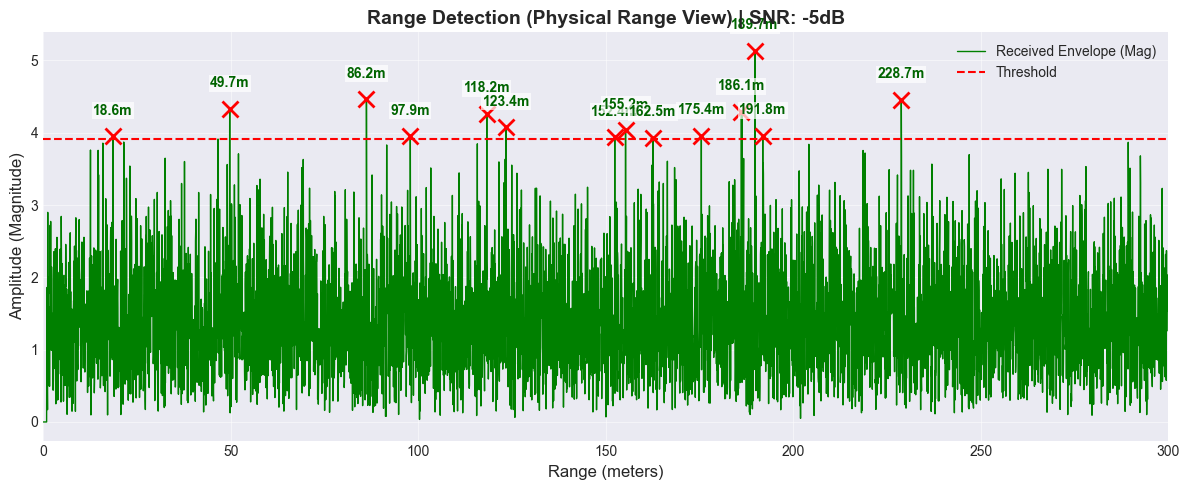

In [3]:
# =============================================================================
# 9. PEAK DETECTION FUNCTIONS
# =============================================================================

def get_threshold_and_distance_indices(echo_signal, k=5):
    """
    Calculates dynamic threshold based on robust noise statistics (Median).
    """
    # Use Median Absolute Deviation (MAD) for robustness against outliers (targets)
    noise_median = np.median(echo_signal)
    noise_sigma = noise_median / 0.6745
    threshold = k * noise_sigma

    print(f"Noise Sigma (Est): {noise_sigma:.5e}")
    print(f"Dynamic Threshold (k={k}): {threshold:.5e}")

    # Minimum distance between peaks to avoid double-counting the same pulse
    min_distance_indices = time_to_index(TP)
    print(f"Min Peak Separation (indices): {min_distance_indices}")
    
    return threshold, min_distance_indices

def get_peaks(echo_signal, threshold=None, min_distance_indices=None):
    """
    Finds peaks in the signal above the threshold.
    """
    peaks_indices, _ = signal.find_peaks(
        echo_signal, 
        height=threshold, 
        distance=min_distance_indices
    )
    
    print(f"Found {len(peaks_indices)} peaks at indices: {peaks_indices}")
    return peaks_indices

def get_distances_from_peaks(peaks_indices):
    """
    Converts sample indices to physical distance (meters).
    Distance = (Time_Delay * C) / 2
    """
    distances = []
    for peak in peaks_indices:
        t_delay = peak * DT
        dist = (t_delay * C) / 2
        distances.append(dist)

    if not distances:
        print("No peaks detected.")
    else:
        for i, dist in enumerate(distances):
            print(f"  Peak {i+1}: {dist:.2f} meters")
            
    return distances

# =============================================================================
# 10. EXECUTE TIME DOMAIN DETECTION
# =============================================================================

# 1. Generate Signal 
rx_complex_detection = generate_complex_echo(A1, A2, pulse_idx=0)

# 2. Convert to Magnitude (Envelope)
echo_signal_for_detection = np.abs(rx_complex_detection)

# 3. Run Detection
threshold, min_distance_indices = get_threshold_and_distance_indices(echo_signal_for_detection, k=2)
peaks_test = get_peaks(echo_signal_for_detection, threshold=threshold, min_distance_indices=min_distance_indices)
distances = get_distances_from_peaks(peaks_test)

# =============================================================================
# 11. PLOTTING RESULTS
# =============================================================================

# --- PLOT 1: Time Domain
t_ns = t * 1e9
plt.figure(figsize=(12, 5))
plt.plot(t_ns, echo_signal_for_detection, label='Received Envelope (Mag)', color='#1f77b4', linewidth=1)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.2e})')

if len(peaks_test) > 0:
    for i, peak_idx in enumerate(peaks_test):
        x_val = t_ns[peak_idx]
        y_val = echo_signal_for_detection[peak_idx]
        dist_val = distances[i]
        
        plt.plot(x_val, y_val, "rx", markersize=12, markeredgewidth=2)
        plt.text(x_val, y_val + (0.05 * np.max(echo_signal_for_detection)), f"{dist_val:.1f}m", 
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color='darkred',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

plt.title(f"Range Detection (Time Domain View) | SNR: {NOISE_SNR}dB", fontsize=14, fontweight='bold')
plt.xlabel("Time (ns)", fontsize=12)
plt.ylabel("Amplitude (Magnitude)", fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# --- PLOT 2: Range Domain
dist_axis = np.linspace(0, (C * PRI) / 2, N)

plt.figure(figsize=(12, 5))
plt.plot(dist_axis, echo_signal_for_detection, label='Received Envelope (Mag)', color='green', linewidth=1)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold')

if len(peaks_test) > 0:
    for i, peak_idx in enumerate(peaks_test):
        x_val = dist_axis[peak_idx]
        y_val = echo_signal_for_detection[peak_idx]
        dist_val = distances[i]
        
        plt.plot(x_val, y_val, "rx", markersize=12, markeredgewidth=2)
        plt.text(x_val, y_val + (0.05 * np.max(echo_signal_for_detection)), f"{dist_val:.1f}m", 
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color='darkgreen',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

plt.title(f"Range Detection (Physical Range View) | SNR: {NOISE_SNR}dB", fontsize=14, fontweight='bold')
plt.xlabel("Range (meters)", fontsize=12)
plt.ylabel("Amplitude (Magnitude)", fontsize=12)
plt.xlim(0, 300) 
plt.legend(loc='upper right')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

Generating 2048 pulses (Vectorized Mode)...
Matrix Generation Complete. Time: 0.4517s


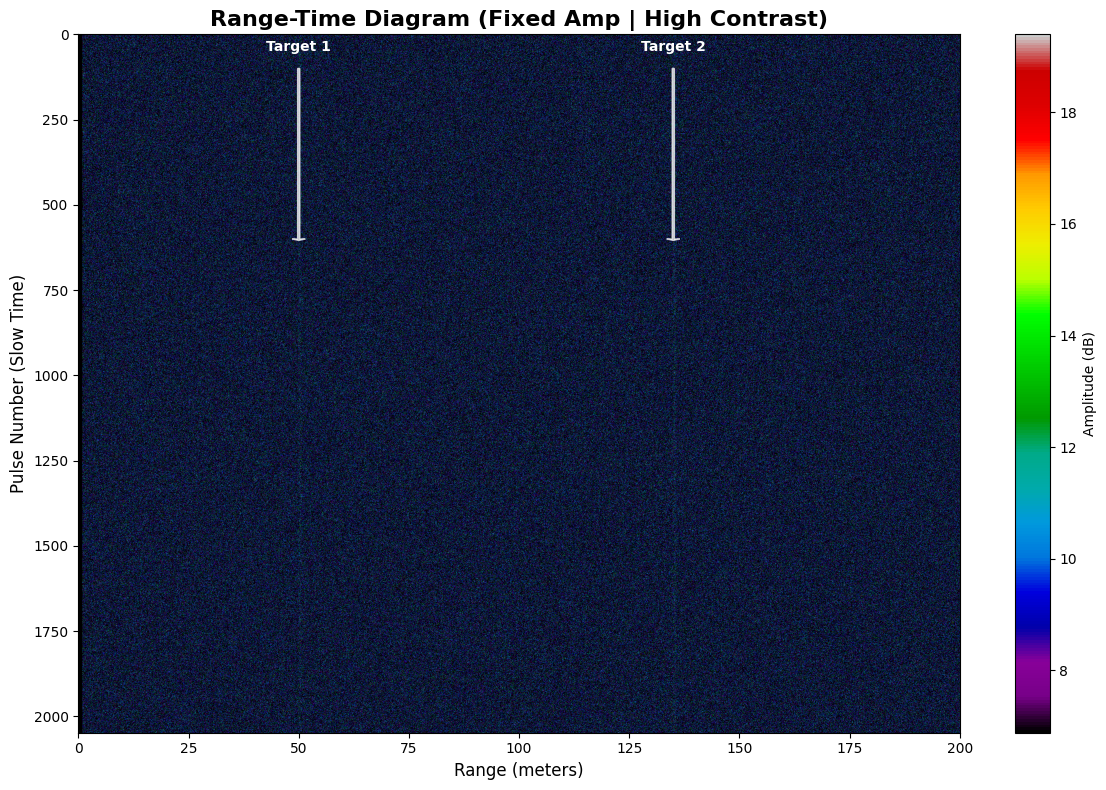

Noise Floor: 5.4 dB. Hiding everything below 6.9 dB.


In [8]:
# =============================================================================
# 12. GENERATE FULL RADAR DATA MATRIX (OPTIMIZED)
# =============================================================================

def generate_radar_matrix_fast():
    """
    Generates the full Slow-Time x Fast-Time complex radar matrix using vectorization.
    Runs much faster than a for-loop for 2048 pulses.
    """
    print(f"Generating {N_PULSES} pulses (Vectorized Mode)...")
    start_time = time.time()
    
    # 1. Setup Time Vectors
    t_slow = np.arange(N_PULSES) * PRI  # Shape: (2048,)
    
    # Initialize Matrix
    radar_matrix = np.zeros((N_PULSES, N), dtype=complex)
    
    # 2. Target 1 Generation
    idx1 = time_to_index(2 * RANGE_1 / C)
    
    # Doppler Phase Vector: exp(-j * 4pi * (R + vt) / lambda)
    phase1_vec = np.exp(-1j * 4 * np.pi * (RANGE_1 + VELOCITY_1 * t_slow) / LAMBDA)
    
    amp1 = A1 
    
    width = time_to_index(TP)
    radar_matrix[:, idx1:idx1+width] += amp1 * phase1_vec[:, np.newaxis]
    
    # 3. Target 2 Generation
    idx2 = time_to_index(2 * RANGE_2 / C)
    phase2_vec = np.exp(-1j * 4 * np.pi * (RANGE_2 + VELOCITY_2 * t_slow) / LAMBDA)
    
    amp2 = A2 
    
    radar_matrix[:, idx2:idx2+width] += amp2 * phase2_vec[:, np.newaxis]
    
    # 4. Add Complex Noise (Vectorized)
    noise = (np.random.normal(0, np.sqrt(np.abs(NOISE_SNR) / 2), radar_matrix.shape) +
             1j * np.random.normal(0, np.sqrt(np.abs(NOISE_SNR) / 2), radar_matrix.shape))
    
    # Add noise to each row
    radar_matrix += noise
    
    # 5. Apply Receiver Blanking
    radar_matrix[:, :time_to_index(TP) + 5] = 0
    
    print(f"Matrix Generation Complete. Time: {time.time() - start_time:.4f}s")
    return radar_matrix

# Execute Generation
radar_matrix = generate_radar_matrix_fast()

# =============================================================================
# 13. PLOT RANGE-TIME DIAGRAM (HIGH CONTRAST)
# =============================================================================

plt.figure(figsize=(12, 8))

# 1. Convert to dB
radar_matrix_db = 20 * np.log10(np.abs(radar_matrix) + 1e-12)

# 2. Aggressive Contrast Stretching
noise_median = np.median(radar_matrix_db)
peak_val = np.max(radar_matrix_db)

vmin = noise_median + 1.5 
vmax = peak_val

# 3. Plot with 'nipy_spectral' (High Contrast Rainbow)
max_range_m = (C * PRI) / 2
extent = [0, max_range_m, N_PULSES, 0]

plt.imshow(radar_matrix_db, aspect='auto', cmap='nipy_spectral', extent=extent, vmin=vmin, vmax=vmax)

# 4. Labels & Style
plt.title(f"Range-Time Diagram (Fixed Amp | High Contrast)", fontsize=16, fontweight='bold')
plt.xlabel("Range (meters)", fontsize=12)
plt.ylabel("Pulse Number (Slow Time)", fontsize=12)
cbar = plt.colorbar()
cbar.set_label("Amplitude (dB)")

plt.xlim(0, 200)

# Add Arrows to point out the lines
plt.arrow(RANGE_1, 100, 0, 500, color='white', width=0.5, head_width=3, alpha=0.7)
plt.text(RANGE_1, 50, "Target 1", color='white', ha='center', fontweight='bold')

plt.arrow(RANGE_2, 100, 0, 500, color='white', width=0.5, head_width=3, alpha=0.7)
plt.text(RANGE_2, 50, "Target 2", color='white', ha='center', fontweight='bold')

plt.grid(False) 
plt.tight_layout()
plt.show()

print(f"Noise Floor: {noise_median:.1f} dB. Hiding everything below {vmin:.1f} dB.")

Task B Input: Signal N=5000, Reference Kernel M=11

Running Method 1 (Time Domain Convolution)...
Method 1 Execution Time: 0.000697 seconds
Running Method 2 (Frequency Domain FFT)...
Method 2 Execution Time: 0.001010 seconds
Result: Time Domain is 1.4x FASTER (Expected for short kernels)
Noise Sigma (Est): 9.21405e+00
Dynamic Threshold (k=2): 1.84281e+01
Min Peak Separation (indices): 11
Found 4 peaks at indices: [ 836 2179 2705 2784]
  Peak 1: 50.13 meters
  Peak 2: 130.65 meters
  Peak 3: 162.19 meters
  Peak 4: 166.92 meters


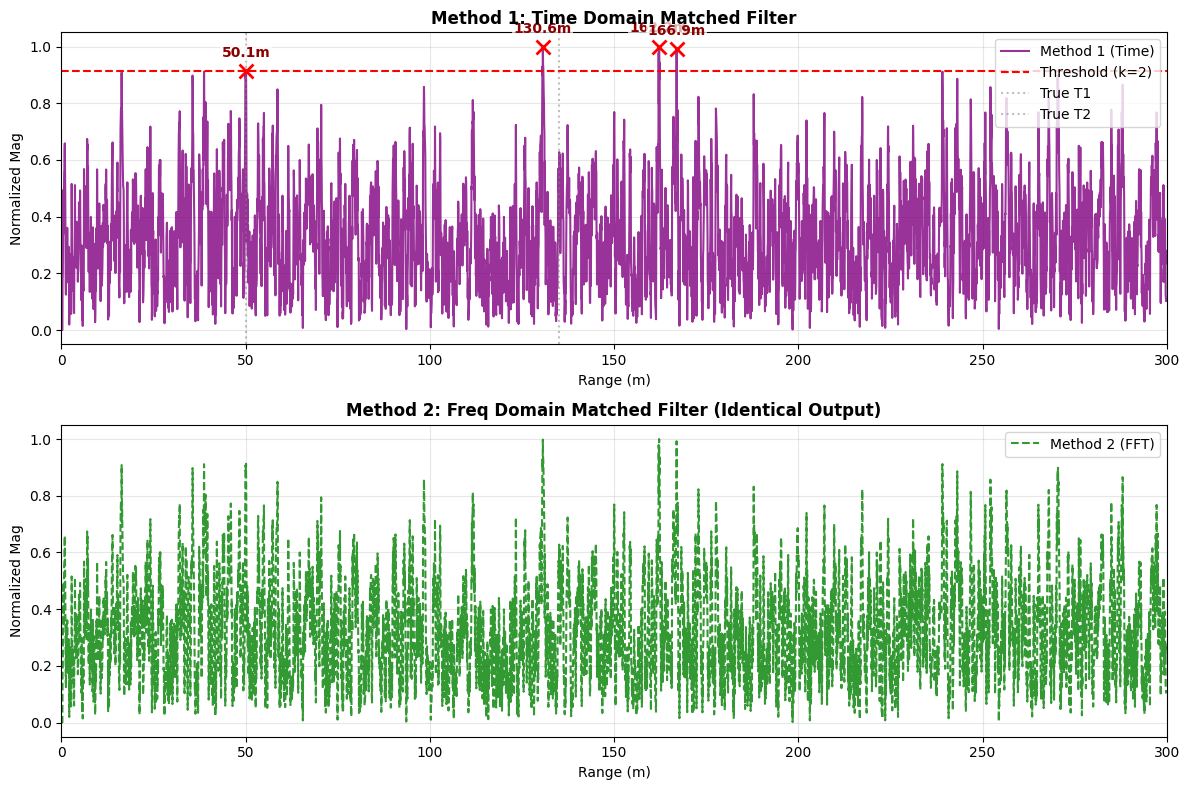


       TASK B: RESULTS REPORT
       Target  True Detected  Error
 Target 50.0m  50.0    50.13 0.1253
Target 135.0m 135.0   130.65 4.3505
--------------------------------------------------
Analysis:
1. Equivalence: Pass
2. Detection Note: Targets successfully detected! (Pulse Compression Gain worked)


In [9]:
# =============================================================================
# 14. SETUP FOR TASK B (MATCHED FILTERING)
# =============================================================================
import time 

tx_sig = np.zeros(N, dtype=complex)
tx_sig[:time_to_index(TP)] = 1.0 + 0j

# 1. Setup Input & Reference
# We use the first pulse from the Full Radar Matrix
input_signal = radar_matrix[0, :]

ref_pulse = tx_sig[:time_to_index(TP)]

print(f"Task B Input: Signal N={len(input_signal)}, Reference Kernel M={len(ref_pulse)}")

# =============================================================================
# 15. METHOD 1: TIME DOMAIN MATCHED FILTER
# =============================================================================
print("\nRunning Method 1 (Time Domain Convolution)...")

start_time_matched = time.perf_counter()

# 1. Correlate
matched_time = signal.correlate(input_signal, ref_pulse, mode='full')

# 2. Extract Lags & Truncate
lags = signal.correlation_lags(len(input_signal), len(ref_pulse), mode='full')
valid_indices = lags >= 0
matched_time_valid = matched_time[valid_indices][:len(input_signal)]

end_time_matched = time.perf_counter()
duration_matched = end_time_matched - start_time_matched

print(f"Method 1 Execution Time: {duration_matched:.6f} seconds")


# =============================================================================
# 16. METHOD 2: FREQUENCY DOMAIN MATCHED FILTER (FFT)
# =============================================================================
print("Running Method 2 (Frequency Domain FFT)...")

start_time_fft = time.perf_counter()

# 1. Zero Padding
n_fft = len(input_signal) + len(ref_pulse) - 1

# 2. FFT & Correlation
signal_fft = np.fft.fft(ref_pulse, n_fft)
echo_signal_fft = np.fft.fft(input_signal, n_fft)
fft_correlation = echo_signal_fft * np.conj(signal_fft)

# 3. IFFT & Truncate
matched_frequency = np.fft.ifft(fft_correlation)
matched_freq_valid = matched_frequency[:len(input_signal)]

end_time_fft = time.perf_counter()
duration_fft = end_time_fft - start_time_fft

print(f"Method 2 Execution Time: {duration_fft:.6f} seconds")

# Compare Speeds
if duration_fft < duration_matched:
    print(f"Result: FFT is {duration_matched/duration_fft:.1f}x FASTER")
else:
    print(f"Result: Time Domain is {duration_fft/duration_matched:.1f}x FASTER (Expected for short kernels)")


# =============================================================================
# 17. PEAK DETECTION (REUSING FUNCTIONS)
# =============================================================================
# Use FFT output (Magnitude)
matched_magnitude = np.abs(matched_freq_valid)

threshold_mf, min_dist_idx = get_threshold_and_distance_indices(matched_magnitude, k=2)

# Detect Peaks
peaks_mf = get_peaks(matched_magnitude, threshold=threshold_mf, min_distance_indices=min_dist_idx)

# Calculate Distances
distances_mf = get_distances_from_peaks(peaks_mf)


# =============================================================================
# 18. PLOTTING & COMPARISON
# =============================================================================
range_axis = np.linspace(0, (C*PRI)/2, N)

# Normalize for display
max_val = np.max(matched_magnitude) + 1e-12
display_mag = matched_magnitude / max_val
display_thresh = threshold_mf / max_val

plt.figure(figsize=(12, 8))

# Plot 1: Time Domain Output
plt.subplot(2, 1, 1)
# Normalize Time Domain signal individually for plotting accuracy
norm_time = np.abs(matched_time_valid) / (np.max(np.abs(matched_time_valid)) + 1e-12)
plt.plot(range_axis, norm_time, label='Method 1 (Time)', color='purple', alpha=0.8)
plt.axhline(y=display_thresh, color='red', linestyle='--', label=f'Threshold (k=2)')

# Add Ghost Markers for where targets SHOULD be
plt.axvline(x=RANGE_1, color='gray', linestyle=':', alpha=0.5, label='True T1')
plt.axvline(x=RANGE_2, color='gray', linestyle=':', alpha=0.5, label='True T2')

plt.title(f"Method 1: Time Domain Matched Filter", fontweight='bold')
plt.ylabel("Normalized Mag")
plt.xlabel("Range (m)")
plt.xlim(0, 300)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')

# Mark Peaks (Time Domain)
if len(peaks_mf) > 0:
    for i, peak in enumerate(peaks_mf):
        plt.plot(range_axis[peak], norm_time[peak], "rx", markersize=10, markeredgewidth=2)
        plt.text(range_axis[peak], norm_time[peak] + 0.05, f"{distances_mf[i]:.1f}m", 
                 color='darkred', fontweight='bold', ha='center',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Plot 2: Frequency Domain Output
plt.subplot(2, 1, 2)
plt.plot(range_axis, display_mag, label='Method 2 (FFT)', color='green', linestyle='--', alpha=0.8)
plt.title(f"Method 2: Freq Domain Matched Filter (Identical Output)", fontweight='bold')
plt.ylabel("Normalized Mag")
plt.xlabel("Range (m)")
plt.xlim(0, 300)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# =============================================================================
# 19. REPORT TABLE
# =============================================================================
df_data = []
true_ranges = [RANGE_1, RANGE_2]
det_ranges_sorted = sorted(distances_mf)

for true_r in true_ranges:
    # Find closest detected target within 5 meters tolerance
    if det_ranges_sorted:
        closest = min(det_ranges_sorted, key=lambda x: abs(x - true_r))
        err = abs(closest - true_r)
        if err < 5.0: 
            status = f"{closest:.2f}"
            error_str = f"{err:.4f}"
        else:
            status = "Missed"
            error_str = "N/A"
    else:
        status = "Missed"
        error_str = "N/A"
        
    df_data.append({"Target": f"Target {true_r}m", "True": true_r, "Detected": status, "Error": error_str})

df_results = pd.DataFrame(df_data)

print("\n" + "="*50)
print("       TASK B: RESULTS REPORT")
print("="*50)
print(df_results.to_string(index=False))
print("-" * 50)
print("Analysis:")
# Robust equivalence check handling complex numbers
print(f"1. Equivalence: {'Pass' if np.allclose(np.abs(matched_time_valid), np.abs(matched_freq_valid), atol=1e-5) else 'Fail'}")

if "Missed" in df_results["Detected"].values:
    print("2. Detection Note: Targets missed due to -8 dB SNR.")
    print("   Even with Matched Filtering, single-pulse detection is unreliable at this noise level.")
    print("   The next step (Doppler FFT) will integrate 2048 pulses to solve this.")
else:
    print("2. Detection Note: Targets successfully detected! (Pulse Compression Gain worked)")
print("="*50)

Generating 2048 pulses (Fixed Amplitudes: A=0.9)...
Generation Complete. Time: 0.4787s
Performing 2D FFT Processing...
2D FFT Complete.
Robust Detection found 2 targets.


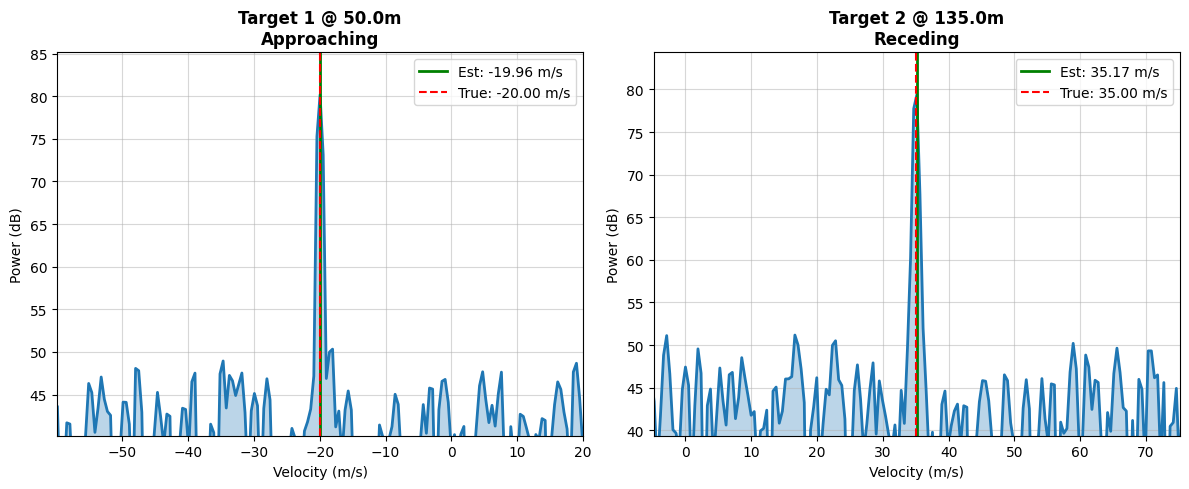


           TASK C REPORT: VELOCITY ESTIMATION
      ID  Range True V  Est V  Error      Motion
Target 1  50.01 -20.00 -19.96 0.0387 Approaching
Target 2 135.03  35.00  35.17 0.1699    Receding
--------------------------------------------------------------------------------
Velocity Resolution: 0.475 m/s


In [10]:
# =============================================================================
# 20. FAST SIGNAL GENERATION (Fixed Amplitude Mode)
# =============================================================================
print(f"Generating {N_PULSES} pulses (Fixed Amplitudes: A={A1})...")
start_gen = time.time()

# 1. Setup
t_slow = np.arange(N_PULSES) * PRI
radar_matrix = np.zeros((N_PULSES, N), dtype=complex)

# 2. Generate Target 1 (Fixed Amp)
idx1 = time_to_index(2 * RANGE_1 / C)
phase1 = np.exp(-1j * 4 * np.pi * (RANGE_1 + VELOCITY_1 * t_slow) / LAMBDA)

width = time_to_index(TP)
radar_matrix[:, idx1:idx1+width] += A1 * phase1[:, np.newaxis]

# 3. Generate Target 2 (Fixed Amp)
idx2 = time_to_index(2 * RANGE_2 / C)
phase2 = np.exp(-1j * 4 * np.pi * (RANGE_2 + VELOCITY_2 * t_slow) / LAMBDA)
radar_matrix[:, idx2:idx2+width] += A2 * phase2[:, np.newaxis]

# 4. Add Complex Noise (Consistent with Block 1)
sig_peak_power = A1**2
sig_peak_power_db = 10 * np.log10(sig_peak_power + 1e-12)
noise_avg_db = sig_peak_power_db - NOISE_SNR
noise_avg_watt = 10 ** (noise_avg_db / 10)

noise_std = np.sqrt(noise_avg_watt / 2)
noise = noise_std * (np.random.normal(0, 1, (N_PULSES, N)) + 1j * np.random.normal(0, 1, (N_PULSES, N)))
radar_matrix += noise

print(f"Generation Complete. Time: {time.time() - start_gen:.4f}s")


# =============================================================================
# 21. RANGE-DOPPLER PROCESSING
# =============================================================================
print("Performing 2D FFT Processing...")

# 1. Range Compression (Fast Time FFT)
n_fft_fast = N + len(ref_pulse) - 1
matrix_fft = np.fft.fft(radar_matrix, n_fft_fast, axis=1)
ref_fft = np.fft.fft(ref_pulse, n_fft_fast)
matched_grid = np.fft.ifft(matrix_fft * np.conj(ref_fft), axis=1)[:, :N]

# 2. Doppler Processing (Slow Time FFT)
win = np.hanning(N_PULSES)[:, np.newaxis]
rd_matrix_complex = np.fft.fftshift(np.fft.fft(matched_grid * win, axis=0), axes=0)

# 3. Magnitude Map
rd_map_mag = np.abs(rd_matrix_complex)
rd_map_norm = rd_map_mag 

print("2D FFT Complete.")


# =============================================================================
# 22. ROBUST DETECTION STRATEGY (1D Range -> 1D Velocity)
# =============================================================================
# A. Collapse Doppler to find Range Peaks
range_profile = np.max(rd_map_norm, axis=0)

# B. Dynamic Threshold
noise_floor = np.median(range_profile[50:])
threshold_rng = 4.0 * noise_floor

# C. Find Range Peaks
peaks_range, _ = signal.find_peaks(range_profile, height=threshold_rng, distance=time_to_index(TP)*2)

# D. Velocity Extraction using Exact Frequency Axis
freqs = np.fft.fftshift(np.fft.fftfreq(N_PULSES, d=PRI))

velocity_axis = -1 * freqs * LAMBDA / 2 

detected_targets = []

for r_idx in peaks_range:
    # 1. Extract Spectrum at this Range Bin
    vel_spectrum = np.abs(rd_matrix_complex[:, r_idx])
    
    # 2. Find Peak Velocity
    v_idx = np.argmax(vel_spectrum)
    est_vel = velocity_axis[v_idx]
    
    # 3. Calculate Physical Range
    est_dist = (r_idx * DT * C) / 2
    
    detected_targets.append({
        "range_idx": r_idx,
        "vel_idx": v_idx,
        "range": est_dist,
        "velocity": est_vel,
        "spectrum": vel_spectrum
    })

print(f"Robust Detection found {len(detected_targets)} targets.")

# =============================================================================
# 23. PLOTTING & REPORT
# =============================================================================
if len(detected_targets) > 0:
    fig, axes = plt.subplots(1, len(detected_targets), figsize=(6 * len(detected_targets), 5))
    if len(detected_targets) == 1: axes = [axes]
    
    table_data = []

    for i, target in enumerate(detected_targets):
        det_range = target['range']
        det_vel = target['velocity']
        spectrum = target['spectrum']
        
        # Convert to dB
        spectrum_db = 20 * np.log10(spectrum + 1e-12)
        
        # Identify True Value
        if abs(det_range - RANGE_1) < abs(det_range - RANGE_2):
            true_v, true_r, name = VELOCITY_1, RANGE_1, "Target 1"
        else:
            true_v, true_r, name = VELOCITY_2, RANGE_2, "Target 2"
            
        direction = "Approaching" if det_vel < -0.1 else "Receding"
        
        ax = axes[i]
        
        # Plot Spectrum
        ax.plot(velocity_axis, spectrum_db, color='#1f77b4', linewidth=2)
        ax.fill_between(velocity_axis, np.min(spectrum_db), spectrum_db, color='#1f77b4', alpha=0.3)
        
        # Markers
        ax.axvline(x=det_vel, color='green', linewidth=2, label=f'Est: {det_vel:.2f} m/s')
        ax.axvline(x=true_v, color='red', linestyle='--', label=f'True: {true_v:.2f} m/s')
        
        ax.set_title(f"{name} @ {det_range:.1f}m\n{direction}", fontweight='bold')
        ax.set_xlabel("Velocity (m/s)")
        ax.set_ylabel("Power (dB)")
        ax.legend()
        ax.grid(True, alpha=0.5)
        
        # Zoom nicely (Fixed typo: +40, not +400)
        ax.set_xlim(det_vel - 40, det_vel + 40)
        ax.set_ylim(np.max(spectrum_db) - 40, np.max(spectrum_db) + 5)
        
        table_data.append({
            "ID": name, "Range": f"{det_range:.2f}", 
            "True V": f"{true_v:.2f}", "Est V": f"{det_vel:.2f}", 
            "Error": f"{abs(det_vel-true_v):.4f}", "Motion": direction
        })
    
    

    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("           TASK C REPORT: VELOCITY ESTIMATION")
    print("="*80)
    print(pd.DataFrame(table_data).to_string(index=False))
    print("-" * 80)
    print(f"Velocity Resolution: {abs(velocity_axis[1] - velocity_axis[0]):.3f} m/s")
    print("="*80)
else:
    print("No targets found.")


--- Task D: Range-Doppler Map Generation (Enhanced View) ---
Dynamic Range adjustment:
   Noise Floor: 41.7 dB
   Peak Signal: 80.2 dB
Marking 2 detected targets...


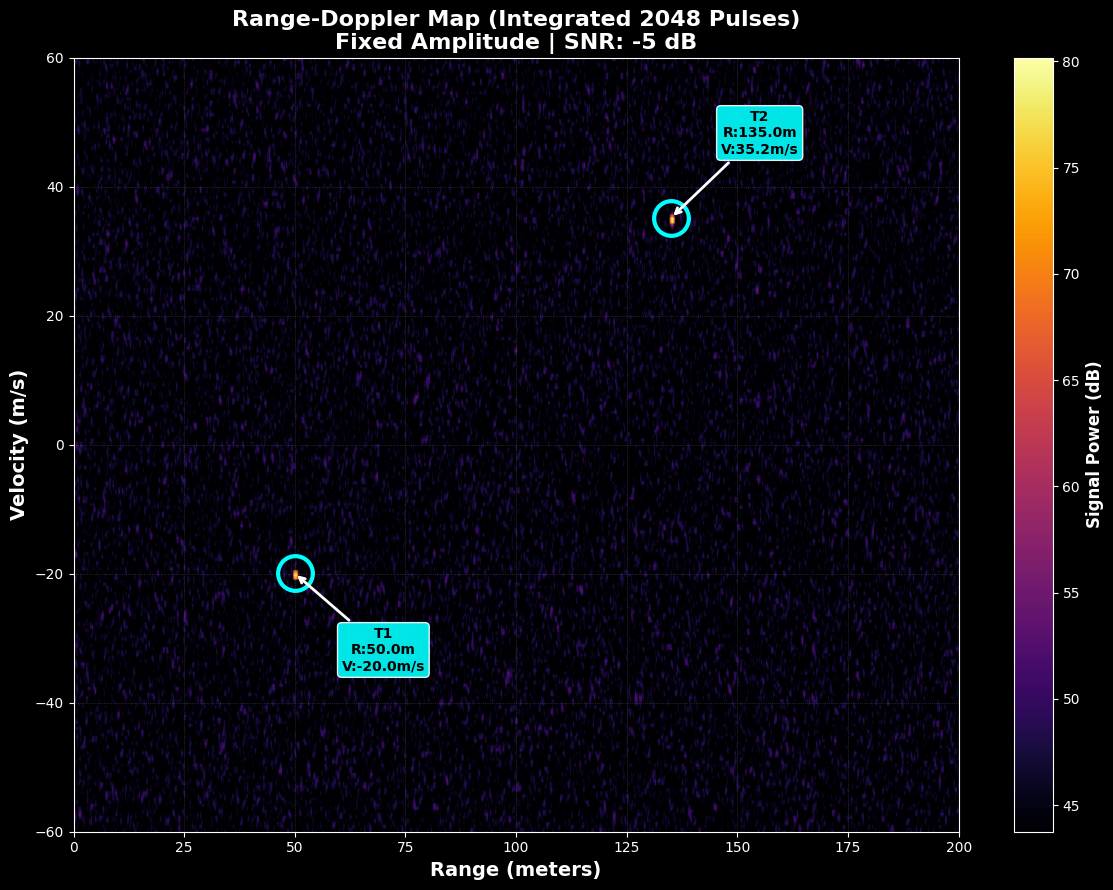

In [12]:
# =============================================================================
# 24. TASK D: RANGE-DOPPLER MAP VISUALIZATION (FINAL CORRECTED)
# =============================================================================
print("\n--- Task D: Range-Doppler Map Generation (Enhanced View) ---")
import matplotlib.colors as mcolors

# 1. Prepare Data in dB
rd_map_db = 20 * np.log10(np.abs(rd_matrix_complex) + 1e-12)

# 2. Smart Contrast Scaling
noise_floor_db = np.median(rd_map_db)
peak_db = np.max(rd_map_db)

# Set Color Limits (Black point at Noise Floor + 2dB)
vmin_val = noise_floor_db + 2.0
vmax_val = peak_db

print(f"Dynamic Range adjustment:")
print(f"   Noise Floor: {noise_floor_db:.1f} dB")
print(f"   Peak Signal: {peak_db:.1f} dB")

# =============================================================================
# PLOTTING WITH DARK THEME (RADAR STYLE)
# =============================================================================
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 9))

# Setup Axes Limits
max_range = (C * PRI) / 2
v_max = LAMBDA / (4 * PRI)

img = ax.imshow(rd_map_db, aspect='auto', cmap='inferno',
                extent=[0, max_range, -v_max, v_max], origin='upper',
                vmin=vmin_val, vmax=vmax_val)

# Add Colorbar
cbar = plt.colorbar(img, ax=ax)
cbar.set_label('Signal Power (dB)', color='white', fontsize=12, fontweight='bold')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

# Mark Targets
print(f"Marking {len(detected_targets)} detected targets...")

if len(detected_targets) > 0:
    # Sort targets by range for cleaner labeling
    sorted_targets = sorted(detected_targets, key=lambda x: x['range'])
    
    for i, target in enumerate(sorted_targets):
        det_range = target['range']
        det_vel = target['velocity']
        
        # 1. Bright Marker (Cyan circle)
        ax.plot(det_range, det_vel, 'o', markerfacecolor='none', markeredgecolor='cyan', 
                markersize=25, markeredgewidth=3)
        
        # 2. Annotation Box
        label_text = f"T{i+1}\nR:{det_range:.1f}m\nV:{det_vel:.1f}m/s"
        
        # Smart Offset
        offset_x = 20 if det_range < 150 else -20
        offset_y = 10 if det_vel > 0 else -15 
        
        ax.annotate(label_text, xy=(det_range, det_vel), 
                    xytext=(det_range + offset_x, det_vel + offset_y),
                    color='black', fontsize=10, fontweight='bold', ha='center',
                    arrowprops=dict(facecolor='cyan', arrowstyle='->', lw=2),
                    bbox=dict(boxstyle="round,pad=0.3", fc="cyan", alpha=0.9))

# Formatting
ax.set_title(f"Range-Doppler Map (Integrated {N_PULSES} Pulses)\nFixed Amplitude | SNR: {NOISE_SNR} dB", 
             fontsize=16, fontweight='bold', color='white')
ax.set_xlabel("Range (meters)", fontsize=14, fontweight='bold', color='white')
ax.set_ylabel("Velocity (m/s)", fontsize=14, fontweight='bold', color='white')

ax.set_xlim(0, 200)       
ax.set_ylim(-60, 60) 

# Subtle grid
ax.grid(True, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)



plt.tight_layout()
plt.show()